Efficient estimation of bid–ask spreads from open, high, low, and close prices 

https://github.com/eguidotti/bidask

In [7]:
import numpy as np


def edge(open: np.array, high: np.array, low: np.array, close: np.array, sign: bool = False) -> float:
    """
    Efficient Estimation of Bid-Ask Spreads from Open, High, Low, and Close Prices

    Implements an efficient estimator of bid-ask spreads from open, high, low, and close prices 
    as described in Ardia, Guidotti, & Kroencke (2024) -> https://doi.org/10.1016/j.jfineco.2024.103916

    Prices must be sorted in ascending order of the timestamp.

    Parameters
    ----------
    - `open`: array-like vector of open prices
    - `high`: array-like vector of high prices
    - `low`: array-like vector of low prices
    - `close`: array-like vector of close prices
    - `sign`: whether signed estimates should be returned

    Returns
    -------
    The spread estimate. A value of 0.01 corresponds to a spread of 1%.
    
    """

    o = np.log(np.asarray(open))
    h = np.log(np.asarray(high))
    l = np.log(np.asarray(low))
    c = np.log(np.asarray(close))
    m = (h + l) / 2.

    h1, l1, c1, m1 = h[:-1], l[:-1], c[:-1], m[:-1]
    o, h, l, c, m = o[1:], h[1:], l[1:], c[1:], m[1:]

    tau = np.logical_or(h != l, l != c1) 
    phi1 = np.logical_and(o != h, tau)
    phi2 = np.logical_and(o != l, tau)
    phi3 = np.logical_and(c1 != h1, tau)
    phi4 = np.logical_and(c1 != l1, tau)
  
    pt = np.nanmean(tau)
    po = np.nanmean(phi1) + np.nanmean(phi2)
    pc = np.nanmean(phi3) + np.nanmean(phi4)
    
    if pt == 0 or po == 0 or pc == 0:
        return np.nan

    r1 = m-o
    r2 = o-m1
    r3 = m-c1
    r4 = c1-m1
    r5 = o-c1
  
    d1 = r1 - tau * np.nanmean(r1) / pt
    d3 = r3 - tau * np.nanmean(r3) / pt
    d5 = r5 - tau * np.nanmean(r5) / pt
  
    x1 = -4./po*d1*r2 -4./pc*d3*r4 
    x2 = -4./po*d1*r5 -4./pc*d5*r4 
  
    e1 = np.nanmean(x1)
    e2 = np.nanmean(x2)
  
    v1 = np.nanmean(x1**2) - e1**2
    v2 = np.nanmean(x2**2) - e2**2
  
    s2 = (v2*e1 + v1*e2) / (v1 + v2)
  
    s = np.sqrt(np.abs(s2))
    if sign and s2 < 0: 
        s = -s
  
    return float(s)

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('data/price/BTCUSDT-spot-2021-10.csv')

In [10]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,1633046400000,43820.01,43820.01,43814.86,43820.01,1.11549,1633046400999,48877.988373,18,0.25020,10963.766502,0
1,1633046401000,43820.01,43820.01,43820.00,43820.00,0.08210,1633046401999,3597.622722,6,0.07219,3163.366522,0
2,1633046402000,43820.01,43820.01,43820.00,43820.00,0.60598,1633046402999,26554.049502,12,0.59024,25864.322702,0
3,1633046403000,43820.01,43820.01,43820.00,43820.01,0.09518,1633046403999,4170.788507,14,0.09068,3973.598507,0
4,1633046404000,43820.00,43820.00,43816.22,43816.22,0.85701,1633046404999,37553.312524,27,0.13199,5783.743454,0


In [11]:
open_np = df['Open'].values
high_np = df['High'].values
low_np = df['Low'].values
close_np = df['Close'].values

In [12]:
window_size = 60

bidask_np = np.zeros(len(open_np))

for i in range(window_size-1, len(open_np)):
    open_window = open_np[i-window_size:i]
    high_window = high_np[i-window_size:i]
    low_window = low_np[i-window_size:i]
    close_window = close_np[i-window_size:i]
    spread = edge(open_window, high_window, low_window, close_window)
    bidask_np[i] = spread
    if i % 100000 == 0:  # 진행 상황 출력
        print(f'{i}: {spread}')

c:\Users\slaye\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\slaye\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\slaye\AppData\Local\Temp\ipykernel_34720\3588741314.py:55: RuntimeWarning: Mean of empty slice
  d1 = r1 - tau * np.nanmean(r1) / pt
C:\Users\slaye\AppData\Local\Temp\ipykernel_34720\3588741314.py:56: RuntimeWarning: Mean of empty slice
  d3 = r3 - tau * np.nanmean(r3) / pt
C:\Users\slaye\AppData\Local\Temp\ipykernel_34720\3588741314.py:57: RuntimeWarning: Mean of empty slice
  d5 = r5 - tau * np.nanmean(r5) / pt
C:\Users\slaye\AppData\Local\Temp\ipykernel_34720\3588741314.py:62: RuntimeWarning: Mean of empty slice
  e1 = np.nanmean(x1)
C:\Users\slaye\AppData\Local\Temp\ipykernel_34720\3588741314.py:63: RuntimeWarning: Mean of empty slice
  e2 = np.nanm

100000: 1.0953351468490405e-05
200000: 7.635604680458393e-06
300000: 1.5711054236905866e-05
400000: 1.3185184496999343e-05
500000: 7.982069235627949e-05
600000: 2.2002479955345575e-05
700000: 9.901261317548303e-06
800000: 1.1656527599286003e-05
900000: 1.0062027770481327e-05
1000000: 4.7969344170851664e-05
1100000: 9.560903308443364e-05
1200000: 4.377013910637841e-05
1300000: 1.9927559891034252e-05
1400000: 1.79282656846923e-05
1500000: 8.63807140799574e-06
1600000: 2.137016416571813e-06
1700000: 4.17275912735891e-05
1800000: 0.00010304520336936039
1900000: 6.4259578433755884e-06
2000000: 2.2155591965872128e-05
2100000: 2.3196493568492825e-05
2200000: 1.6050324355399592e-05
2300000: 9.854880707333956e-06
2400000: 0.001371143705603744
2500000: 2.9818639126347273e-05
2600000: 1.4328707453093478e-05


In [13]:
# bidask_df = pd.DataFrame(bidask_np, columns=['Spread'])
df['Spread'] = bidask_np

In [14]:
df.to_csv('data/price/BTCUSDT-spot-2021-10_sec_spread.csv', index=False)

In [15]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,Spread
0,1633046400000,43820.01,43820.01,43814.86,43820.01,1.11549,1633046400999,48877.988373,18,0.25020,10963.766502,0,0.0
1,1633046401000,43820.01,43820.01,43820.00,43820.00,0.08210,1633046401999,3597.622722,6,0.07219,3163.366522,0,0.0
2,1633046402000,43820.01,43820.01,43820.00,43820.00,0.60598,1633046402999,26554.049502,12,0.59024,25864.322702,0,0.0
3,1633046403000,43820.01,43820.01,43820.00,43820.01,0.09518,1633046403999,4170.788507,14,0.09068,3973.598507,0,0.0
4,1633046404000,43820.00,43820.00,43816.22,43816.22,0.85701,1633046404999,37553.312524,27,0.13199,5783.743454,0,0.0


<Axes: >

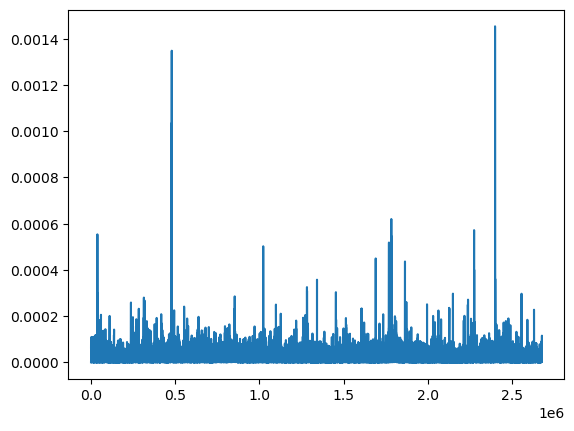

In [19]:
df.Spread.plot()